<a href="https://colab.research.google.com/github/aahFancyGun/dataScienceClass/blob/master/unit8/YangChauUnit8Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import graphviz as gr
import pandas as pd
import pymc as pm
import seaborn as sns

In [6]:
!pip install pymc-bart

<font face="times" size=100px color='blue' font-style='bold'> Unit 8 Project: Predicting Nuclear Energy Trends <font>

<font face="times" size=5px color='blue' font-style='bold'> Part 2: Electric Boogaloo <font>


In [7]:
import pymc_bart as pmb

#Introduction

## The "Big" Goal

My goal in doing this project is to improve on my previous efforts to predict nuclear energy production by using a BART model as I noticed some innacuracies in my old models that made them good at matching the data but not very good at predicting reality. Additionally, I'd like to gain a better understanding of how the varaibles in my dataset act with one another and the importance each of them has on predicting nuclear energy on a whole.

- Currently, based off my previous project, I believe year will be the most important variable, as it's only natural that nuclear energy should scale with the amount of time that it has actually existed.

## To be Specific.

One thing that I noticed was pretty uniform all the models in my previous project was the prescense of an element in the graphed model that simply would never happen in real life. Even in my final model, near the beginning, it impossibly tapers up, which doesn't model reality in the slightest. Because of that, I'd like to see if I can model something that fits more closely to the data while staying true to reality even beyond the reach of the data.

## Context

Nuclear energy generation is one of the most cutting edge forms of energy generation currently in humanity's arsenal and can be seen as something of a middle ground between renewable non-renewable energy resources.
  - While nuclear energy generation does produce waste, the majority of this waste is harmless and the rest is easily and safely stored.
    - non-renewable wastes are instead unsafely stored in the air we breathe
  - In general, much more favorable ratio of energy generated per square foot taken up than all known renewables
  - Fuel can be recycled into more energy creating a sort of quasi renewable energy source

# Data Wrangling

## Specificities

The number one thing you need to know about this data is that I'm cutting out around a third of it and starting at 265th row. The reason I did this is simply because before this row, not all columns had defined data, and at certain instances, a few columns simply had "undefined" in a cell.

- As for nitty gritty stuff, this dataset covers several important elements in tracking Nuclear power generation which I will list out briefly below

  - Nuclear Generating Units, Total Operable Units: The total number of operable nuclear generating units (data is only 100% available starting at row 265).

  - Nuclear Generating Units, Net Summer Capacity: The net summer capacity of nuclear generating units in million kilowatts.

  - Nuclear Electricity Net Generation: The net generation of electricity from nuclear power in millions of kilowatt-hours.

  - Nuclear Share of Electricity Net Generation: The percentage share of total electricity net generation coming from nuclear power.

  - Nuclear Generating Units, Capacity Factor: The capacity factor (actual output vs potential output) of nuclear generating units.

### Sourcing

This dataset was sourced from a kaggle dataset that was formed from various reputable sources like the U.S. Energy Information Administration (EIA), the World Resources Institute, the Ember Climate, the U.S. Nuclear Regulatory Commission (NRC), and Our World in Data.

In [8]:
url = "https://raw.githubusercontent.com/aahFancyGun/dataScienceClass/master/unit7/nuclear_energy_overview_eia.csv"

data = pd.read_csv(url)[264:] #reading data

data = data.rename(columns={
    'Year': 'Year',
    'Month': 'Month',
    'Nuclear_Generating_Units_Total__Operable_Units': 'Operable_Units',
    'Nuclear_Generating_Units_Net_Summer_Capacity': 'Summer_Capacity_MW',
    'Nuclear_Electricity_Net_Generation': 'Electricity_Generated_MWh',
    'Nuclear_Share_of_Electricity_Net_Generation': 'Electricity_Share_Percent',
    'Nuclear_Generating_Units_Capacity_Factor': 'Capacity_Factor'
})

data #printing data

,Year,Month,Operable_Units,Summer_Capacity_MW,Electricity_Generated_MWh,Electricity_Share_Percent,Capacity_Factor
264,1995,January,109,99.148,63342,22.6,85.9
265,1995,February,109,99.148,51858,20.6,77.8
266,1995,March,109,99.148,51880,19.9,70.3
267,1995,April,109,99.148,49321,20.2,69.2
268,1995,May,109,99.148,54387,20.6,73.7
...,...,...,...,...,...,...,...
609,2023,October,93,95.746,61403,18.6,86.2
610,2023,November,93,95.746,62258,19.3,90.3
611,2023,December,93,95.746,68898,19.9,96.7
612,2024,January,93,95.723,69080,18.2,97.1


,Year,Month,Operable_Units,Summer_Capacity_MW,Electricity_Generated_MWh,Electricity_Share_Percent,Capacity_Factor
264,1995,January,109,99.148,63342,22.6,85.9
265,1995,February,109,99.148,51858,20.6,77.8
266,1995,March,109,99.148,51880,19.9,70.3
267,1995,April,109,99.148,49321,20.2,69.2
268,1995,May,109,99.148,54387,20.6,73.7
...,...,...,...,...,...,...,...
609,2023,October,93,95.746,61403,18.6,86.2
610,2023,November,93,95.746,62258,19.3,90.3
611,2023,December,93,95.746,68898,19.9,96.7
612,2024,January,93,95.723,69080,18.2,97.1


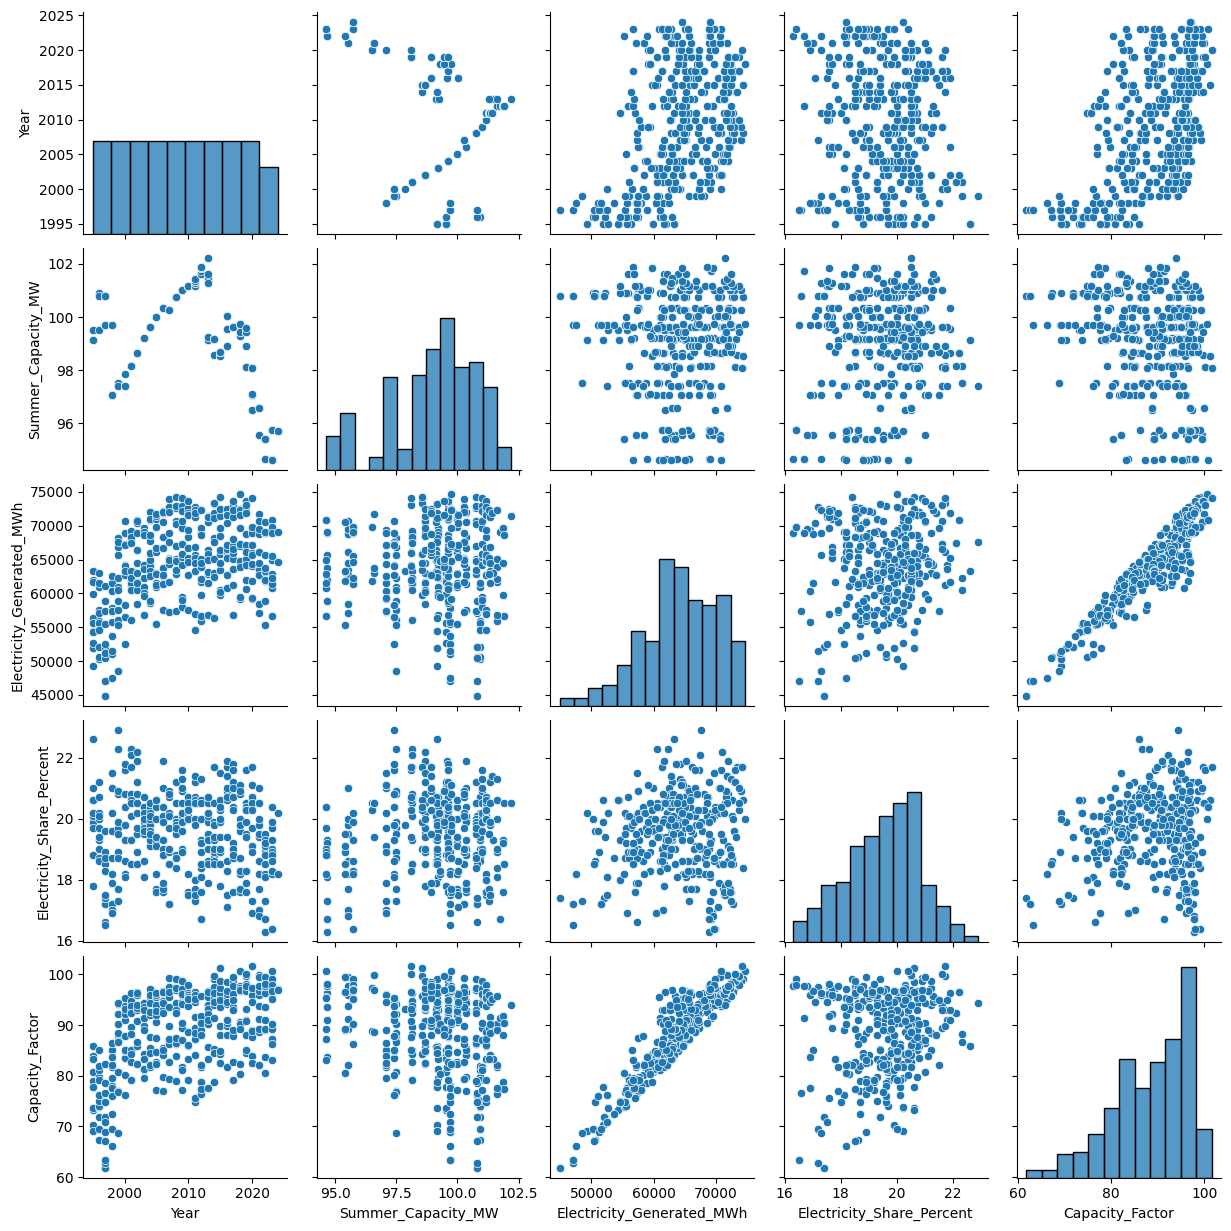

In [9]:
sns.pairplot(data)

## Scatterplot
By looking at the plot I can better choose a model that I feel will do a good job of modeling my data.

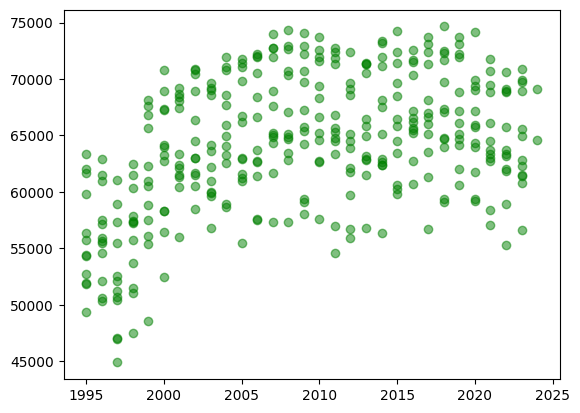

In [10]:
plt.scatter(data["Year"], data["Electricity_Generated_MWh"], color='green', alpha=0.5)
plt.show()

## Initial opinions

Appears logarithmic while plotted against what I believe to be one of the most important variables (year). For this reason, I'll be choosing preliz's Logarithmic model.

## Chosen Variables

 For this project, instead of focusing wholey on matching the data I'd like to concentrate more on predicting an overall pattern to nuclear energy generation. For this reason, I'll be cutting out the 'month' variable, as I don't believe it needed to create a BART that can model a multi-year trend.

 - From my last project I know that the 'month' variable serves to differentiate a trend for each of 12 months but as it can only be represented numerically from 1-12 it'd essentially be mapping the same value to different nuclear net generation values.
  - For example: january one year will produce 1 joule of energy but the next year produces 10 bazillion. It introduces a lot of potential problems basically.

In [11]:
X = data[["Year", "Operable_Units", "Summer_Capacity_MW", "Electricity_Share_Percent", "Capacity_Factor"]].astype(float)
Y = data["Electricity_Generated_MWh"].to_numpy()

# Causal Diagram

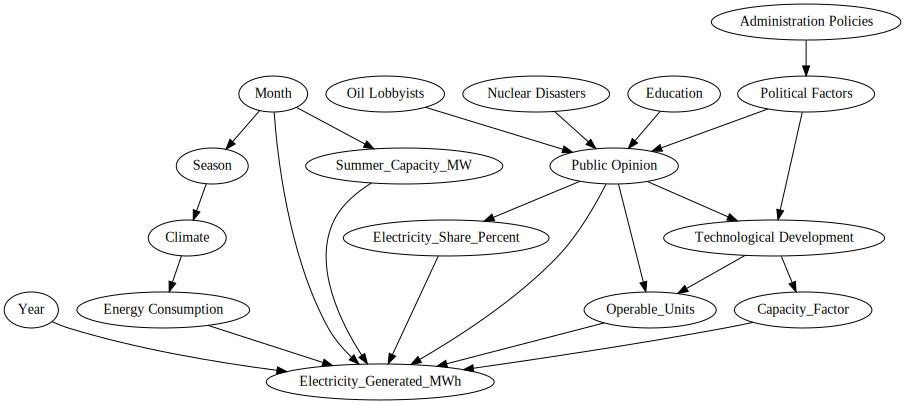

In [12]:
dot = gr.Digraph(format = 'png')

dot.node("Electricity_Generated_MWh") # Predicted Variable

# 6 Primary Predictors
dot.node("Year")
dot.node("Month")
dot.node("Operable_Units")
dot.node("Summer_Capacity_MW")
dot.node("Electricity_Share_Percent")
dot.node("Capacity_Factor")

# Secondary Predictors
dot.node("PR", "Public Opinion")
dot.node("Season")
dot.node("Nuclear Disasters")
dot.node("Technological Development")
dot.node("Season")
dot.node("Climate")
dot.node("Energy Consumption")
dot.node("Education")
dot.node("Political Factors")
dot.node("Oil Lobbyists")
dot.node("Administration Policies")

dot.edge("Year", "Electricity_Generated_MWh")
dot.edge("Month", "Electricity_Generated_MWh")
dot.edge("Operable_Units", "Electricity_Generated_MWh")
dot.edge("Summer_Capacity_MW", "Electricity_Generated_MWh")
dot.edge("Electricity_Share_Percent", "Electricity_Generated_MWh")
dot.edge("Capacity_Factor", "Electricity_Generated_MWh")

dot.edge("PR", "Electricity_Generated_MWh")
dot.edge("Season", "Climate")
dot.edge("Climate", "Energy Consumption")
dot.edge("Energy Consumption", "Electricity_Generated_MWh")
dot.edge("Nuclear Disasters", "PR")
dot.edge("Education", "PR")
dot.edge("PR", "Technological Development")
dot.edge("Technological Development", "Capacity_Factor")
dot.edge("Month", "Summer_Capacity_MW")
dot.edge("Month", "Season")
dot.edge("PR", "Electricity_Share_Percent")
dot.edge("Technological Development", "Operable_Units")
dot.edge("PR", "Operable_Units")
dot.edge("Political Factors", "Technological Development")
dot.edge("Oil Lobbyists", "PR")
dot.edge("Political Factors", "PR")
dot.edge("Administration Policies", "Political Factors")


dot


# BART

## Specs

For my initial model, I'll be using a logistic BART model

In [13]:
with pm.Model() as model_nu:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", X, Y, m=50)
    μ = pm.Deterministic("μ", μ_)
    y = pm.Logistic("y", mu=μ, s=s, observed=Y)
    idata_nu = pm.sample(compute_convergence_checks=False)

Output()

Output()

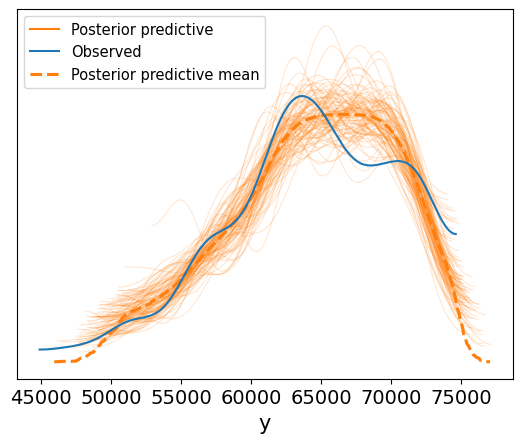

In [14]:
pm.sample_posterior_predictive(idata_nu,model_nu, extend_inferencedata=True)
ax = az.plot_ppc(idata_nu, num_pp_samples=100, colors=["C1", "C0", "C1"])


##Initial Analysis

ALthough the peak and right tail deviate greatly from the observed data the left tail conforms somewhat consistently to the observed data. Additionally, you can see that while the majority of predictions by the model lose accuracy following the peak of the observed data, there are still some small organge lines that trace a more correct path. Judging from this, I can see that while my BART model isn't amazing, it will still be a good starting point to build off of.

## PPC

In [15]:
posterior_mean = idata_nu.posterior["μ"]

μ_hdi = az.hdi(ary=idata_nu, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_nu, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


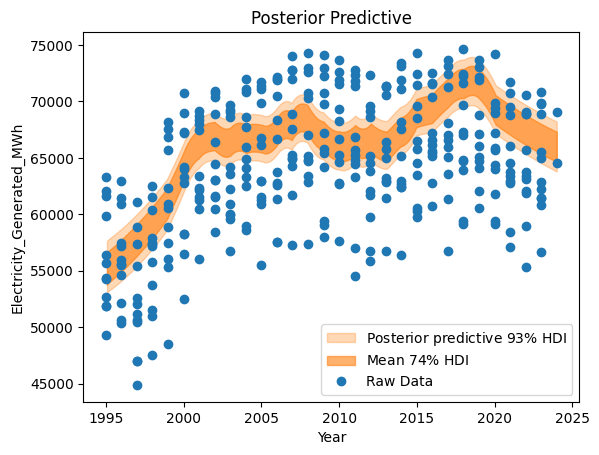

In [16]:
idx = np.argsort(X.to_numpy()[:, 0]) #grab first row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab first row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab first row
    y=pps,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(data['Year'], data["Electricity_Generated_MWh"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Year",
    ylabel="Electricity_Generated_MWh",
);

## PPC Analysis

At first glance this appears like a pretty bad model, at least when it comes to predicting on my data, but when looked at more closely you can see that it closely follows the overall observed trend, even to the point where I'm a little concerned it's overfitting. Additionally, from my previous project I know that this data can essentially be divided into twelve different models corresponding for each of the months that all follow the same overall trend.

# Variable Importance Comparisons
## Feat. VI, PD, and ICE Plots

<Axes: ylabel='R²'>

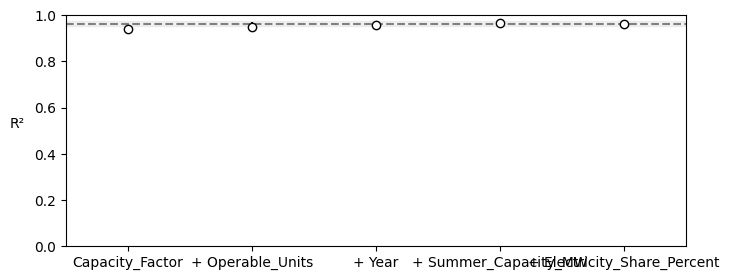

In [17]:
vi_nu = pmb.compute_variable_importance(idata_nu, μ_, X)
pmb.plot_variable_importance(vi_nu)

## Analysis

Contrary to my predictions, the VI grpah appears to put Capacity_Factor as the most important variable. This comes an extreme surprise because in my previous project, while models with capacity_factor scored the highest in ELPD_loo, their actual ability to match my data or even relaity for that matter was subpar at best. Given that this is just about every type of data that is tracked from nuclear energy generation it's not really surprising that the R^2 term is as high as it is, but I'm still curious as to what the other graphs have to say about Capacity_Factor.

array([<Axes: xlabel='Year'>, <Axes: xlabel='Operable_Units'>,
       <Axes: xlabel='Summer_Capacity_MW'>,
       <Axes: xlabel='Electricity_Share_Percent'>,
       <Axes: xlabel='Capacity_Factor'>], dtype=object)

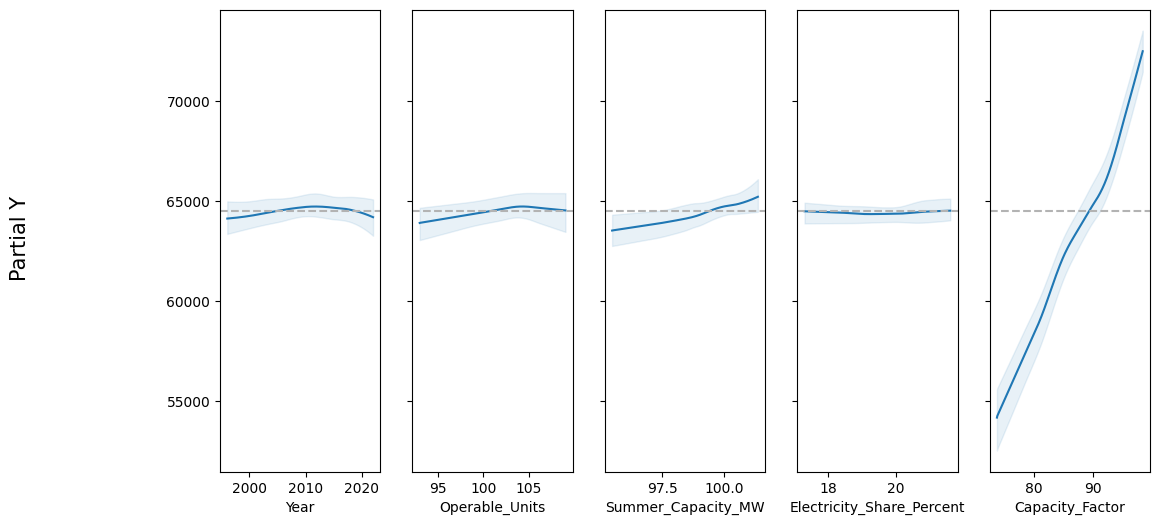

In [18]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), figsize = (12,6))

array([<Axes: xlabel='Year'>, <Axes: xlabel='Operable_Units'>,
       <Axes: xlabel='Summer_Capacity_MW'>,
       <Axes: xlabel='Electricity_Share_Percent'>,
       <Axes: xlabel='Capacity_Factor'>], dtype=object)

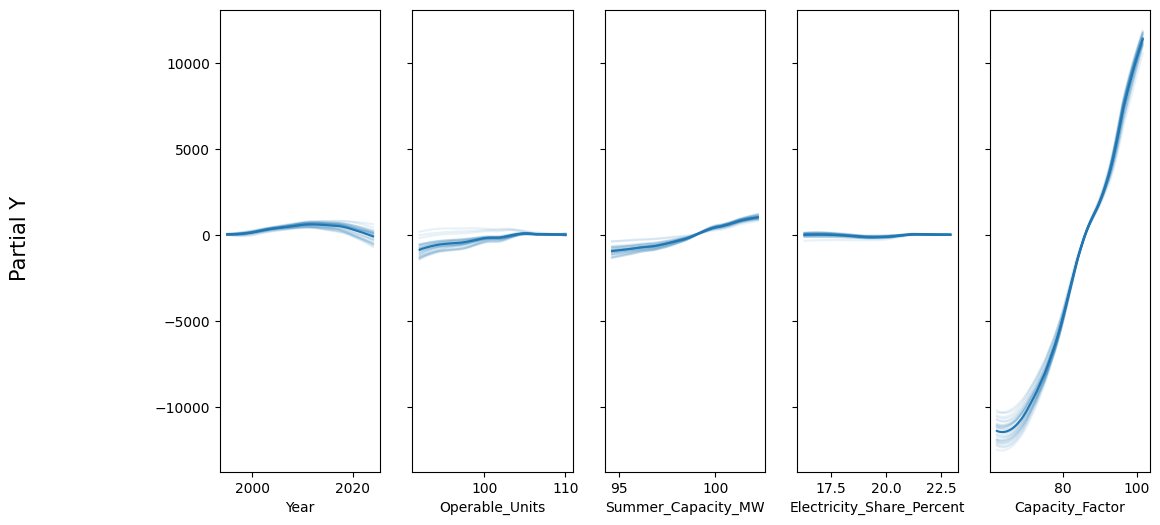

In [19]:
pmb.plot_ice(μ_, X, Y, grid=(1, 5), figsize = (12,6))

## Analysis II

So it seems like the ICE and PD are in agreement with VI about the importance of different variables but they also add on to the overall picture. In the ICE plot, we can observe that all variables have very few non-parallel lines, suggesting very little interaction between variables. Additionally, the Summer_Generated_Capacity variable appears to be the second most important variable, which is really interesting because the data it catalogues only applies to some specific months.

Even more shockingly though is that based off the ICE and PD graphs, it could be surmized that the 'year' variable may actually be harming the accuracy of the model, as can be indicated by the slight downward trend it follows in both the ICE and PD graphs. In addition to variables that harm rather than help, it appears that electricity_share_percent actually decreases the R^2 value, which in contrast to the 'year' variable results, isn't really much of a surprise. I expected that given all other forms of energy were also growing, the share of the energy market that nuclear has might very well just be almost constant throughout the years.

## What's next?

As an experiment, I'd like to build and evaluate another model but with the caveat that I won't be including capacity factor in this one. Like in my previous project, I'm not sure that the best model can be made by blindly following the tools provided to me by various APIs. In fact, in my last project, I actively chose a B-spline that was rated quite poorly according to ELPD_Loo, so I'm curious to see if I can do the same here.

In [20]:
X = data[["Year", "Operable_Units", "Summer_Capacity_MW", "Electricity_Share_Percent"]].astype(float)
Y = data["Electricity_Generated_MWh"].to_numpy()

In [21]:
with pm.Model() as model_nu:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", X, Y, m=50)
    μ = pm.Deterministic("μ", μ_)
    y = pm.Logistic("y", mu=μ, s=s, observed=Y)
    idata_nu = pm.sample(compute_convergence_checks=False)

Output()

Output()

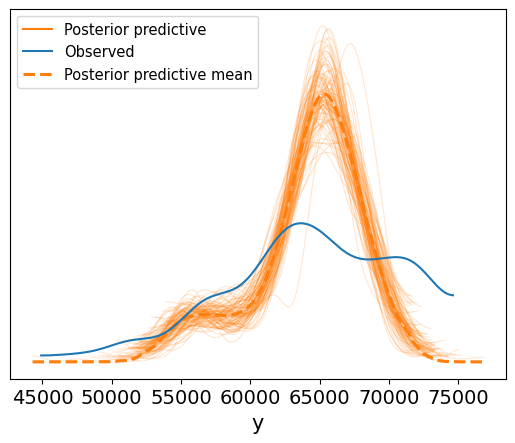

In [22]:
pm.sample_posterior_predictive(idata_nu,model_nu, extend_inferencedata=True)
ax = az.plot_ppc(idata_nu, num_pp_samples=100, colors=["C1", "C0", "C1"])


## Analysis

So it seems I'm not quite so lucky this time, which means that something about the capacity factor variable truly makes it the end all be all for predicting nuclear energy trends.

# Investigation

As stated in my introduction, one of my goals was to not only create a better model compared to my last project but also to understand how each of the variables in my dataset can be used to predict nuclear energy generation. But as things have turned out to heavily favor a single variable, I'm doing to be focusing on trying to figure out why exactly capacity factor is as vital as it is.

## Scatterplot

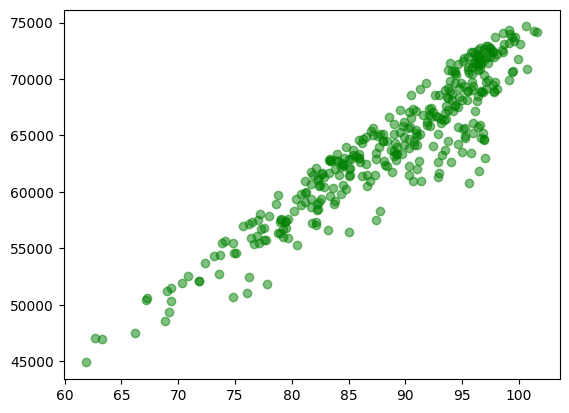

In [23]:
plt.scatter(data["Capacity_Factor"], data["Electricity_Generated_MWh"], color='green', alpha=0.5)
plt.show()

## Analysis

Thankfully, it seems like we didn't have to go very far to get our answer. Compared with plotting the year vs nuclear net energy generation plotting capacity_factor against nuclear net energy generation yields a nearly perfect linear line and very tight groupings, which suggests an extremely close correlation between the two variables.

#### But Why is This?

One of my other variables (year) should also logically have a similar relationship to nuclear energy
- Logically, as years progress, new technology will develop and more powerplants will be built resulting in more nuclear energy generated

Despite that however, it simply doesn't, and can't even begin to compare to the important that is seemingly placed on capacity_factor. In fact, as mentioned earlier, year may be the weakest variable overall, to the point where it may be actively harming the overall accuracy of my model.

I think it's possible that because the data doesn't differentiate based on month, the overall trend when graphing year against nuclear net energy simply appears to be nothing but a blob. As we discovered from the last project, there is a very distinct trend for each of the 12 months, and it can certainly be said that without that, the validity of the year variable as a predictor becomes extremely questionable.


# Final Model

As a final model, I'll be modifying my original first model in strict accordance with the information given to me by the VI, ICE, and PDP graphs.

- Removing Year
- Removing Electiricty_Share_Percent
- Bringing Back Capacity_Factor

In [24]:
X = data[["Capacity_Factor", "Operable_Units", "Summer_Capacity_MW"]].astype(float)
Y = data["Electricity_Generated_MWh"].to_numpy()

In [25]:
with pm.Model() as model_nu:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", X, Y, m=50)
    μ = pm.Deterministic("μ", μ_)
    y = pm.Logistic("y", mu=μ, s=s, observed=Y)
    idata_nu = pm.sample(compute_convergence_checks=False)

Output()

Output()

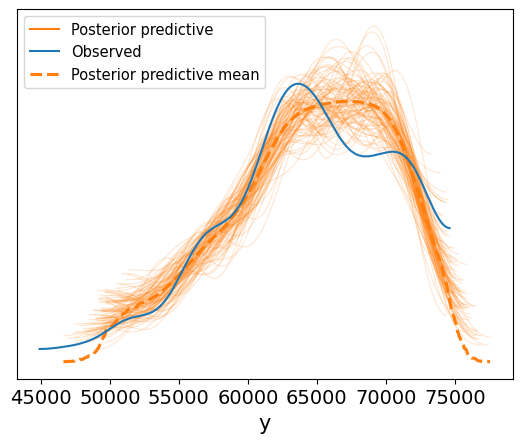

In [26]:
pm.sample_posterior_predictive(idata_nu,model_nu, extend_inferencedata=True)
ax = az.plot_ppc(idata_nu, num_pp_samples=100, colors=["C1", "C0", "C1"])


## Initial Thoughts

It's probably too soon to say anything conclusive but I think that this model is a little better at modeling the actual peak of the graph, with a lot more orange lines going a lot closer to the observed data. Other than that, this doens't appear to be a super meaningful improvement over the initial model.

<Axes: ylabel='R²'>

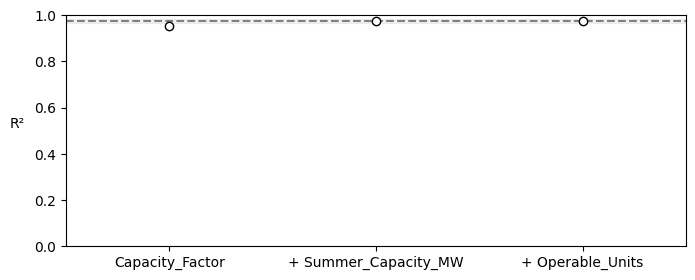

In [27]:
vi_nu = pmb.compute_variable_importance(idata_nu, μ_, X)
pmb.plot_variable_importance(vi_nu)

## Analysis

R^2 appears to remain the same regardless of the removal of two variables and though that might seem like we pointlessly removed two variables I would argue that this is actually a victory. Models that incorporate more and more variables tend to be overly complex, prone to overfitting, and hard to understand as it becomes extremely difficult to isolate and explain relationships between variables and the predicted data. So the fact that I can get a equal or marginally superior result with less variables is very good.

array([<Axes: xlabel='Capacity_Factor'>, <Axes: xlabel='Operable_Units'>,
       <Axes: xlabel='Summer_Capacity_MW'>], dtype=object)

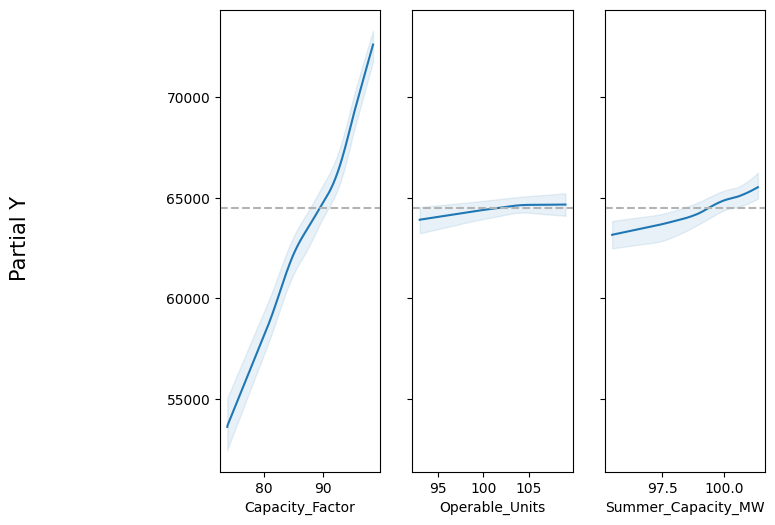

In [28]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), figsize = (12,6))

array([<Axes: xlabel='Capacity_Factor'>, <Axes: xlabel='Operable_Units'>,
       <Axes: xlabel='Summer_Capacity_MW'>], dtype=object)

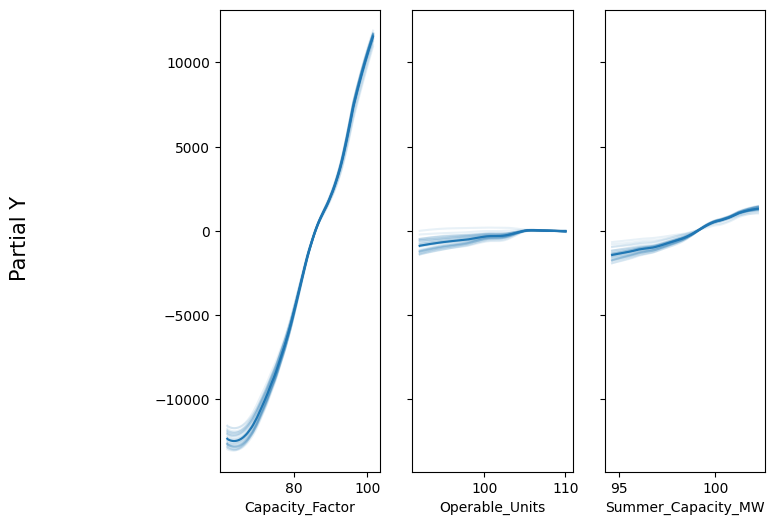

In [29]:
pmb.plot_ice(μ_, X, Y, grid=(1, 5), figsize = (12,6))

# Parting Thoughts

Between my very first model and this one, the raw ability to predict on my data hasn't really changed but as mentioned earlier, I believe this to be quite a victory that the ability of the model can be preserved through all the modifications I've done to it. Additionally, as can be observed by looking at our posterior predictive, the model definitely isn't overfitting and while it might be underfitting to a degree, I think it still preserves the overarching pattern found in the data, so I'd say that I've accomplished one of my goals of building a better model using BART.

As for my second goal, the analysis and understanding of the variables in my dataset, I'd say I've done a lot for that as well. Before this project, I wasn't really sure how my variables interacted with each other or which variables in specific held the most importance in predicting nuclear net generation. But now I know that Capacity_Factor is by far the most important element in nuclear predictions and that my variables in general don't really interact with eachother.

## But Why Capacity_Factor?

Capacity_Factor, as stated in the introductory glossary is the ratio between actual generated energy in a period of time and maximum energy that could've been generated in that period of time. It makes a lot of sense that higher and higher ratios (85%+) correlate with more nuclear energy generated not only because more energy generated in a given period obviously means more well, energy generated but also because more and more efficient nuclear reactors will have higher and higher capacity_factors, so this variable can also account for technological development.